In [1]:
from mfbml.methods.mf_rbf_gpr import MFRBFGPR
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import (
    Forrester_1c,
    Forrester_1a,
    Forrester_1b,
)
from scipy.linalg import cholesky, solve
from scipy.optimize import minimize

# import accuracy measures
from sklearn.metrics import r2_score
from mfbml.get_methods.accuracy_metrics import (
    normalized_mae,
    normalized_rmse,
    log_likelihood_value,
)
import warnings

warnings.filterwarnings("ignore")

In [2]:
func = Forrester_1b()

noise_add1 = 0.3
num_hf_samples = 30
num_lf_samples = 200
optimizer_restart = 20
# define sampler
sampler = MFSobolSequence(design_space=func.design_space, seed=5)
sample_x = sampler.get_samples(
    num_hf_samples=num_hf_samples, num_lf_samples=num_lf_samples
)

sample_y1 = {}
# get response
sample_y1["hf"] = func.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add1, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y1["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add1, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func.hf(test_x)
test_ly = func.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + np.random.normal(
    0, noise_add1, size=test_x_noisy.shape[0]
).reshape(-1, 1)

In [3]:
# for developed methods
# start_time = time.time()
mfrbfgp1 = MFRBFGPR(
    design_space=func.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp1.train(samples=sample_x, responses=sample_y1)

mfrbfgp theta:  [5.45683365]
mfrbfgp beta:  [[3.89222228]
 [1.78581673]]
mfrbfgp noise:  0.37667547595210504


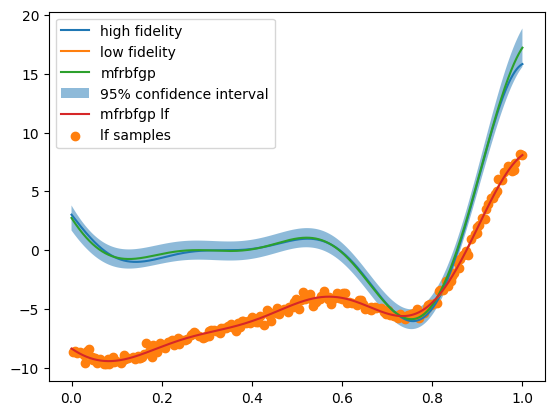

In [4]:
mfrbfgp_pred_y1, mfrbfgp_pred_std1 = mfrbfgp1.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1 = mfrbfgp1.predict_lf(test_xl=test_x)

print("mfrbfgp theta: ", mfrbfgp1.kernel.param)
print("mfrbfgp beta: ", mfrbfgp1.beta)
print("mfrbfgp noise: ", mfrbfgp1.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y1, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y1 - 1.96 * mfrbfgp_pred_std1).flatten(),
    (mfrbfgp_pred_y1 + 1.96 * mfrbfgp_pred_std1).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y1["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [5]:
# add more noise to the low fidelity
noise_add_2 = 0.5
sample_y2 = sample_y1.copy()
sample_y2["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add_2, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

In [6]:
# train the model
mfrbfgp2 = MFRBFGPR(
    design_space=func.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp2.train(samples=sample_x, responses=sample_y2)
mfrbfgp_pred_y2, mfrbfgp_pred_std2 = mfrbfgp2.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly2 = mfrbfgp2.predict_lf(test_xl=test_x)

print("mfrbfgp theta: ", mfrbfgp2.kernel.param)
print("mfrbfgp beta: ", mfrbfgp2.beta)
print("mfrbfgp noise: ", mfrbfgp2.noise)
# plot

mfrbfgp theta:  [4.33590355]
mfrbfgp beta:  [[3.76388184]
 [1.80674814]]
mfrbfgp noise:  0.40534309567727766


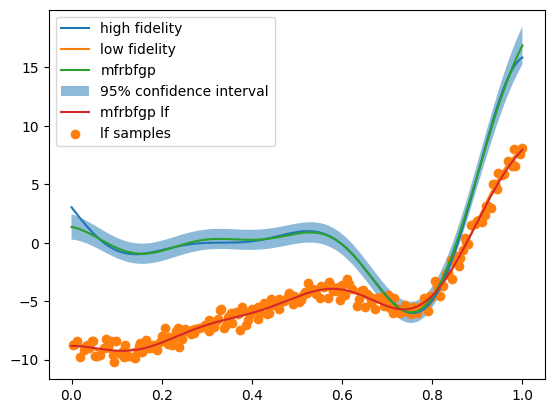

In [7]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y2, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y2 - 1.96 * mfrbfgp_pred_std2).flatten(),
    (mfrbfgp_pred_y2 + 1.96 * mfrbfgp_pred_std2).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly2, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y2["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

In [8]:
# add more noise to the low fidelity
noise_add_3 = 1.0
sample_y3 = sample_y1.copy()
sample_y3["lf"] = func.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add_3, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

In [9]:
# train the model
mfrbfgp3 = MFRBFGPR(
    design_space=func.input_domain,
    noise_prior=None,
    optimizer_restart=optimizer_restart,
)
mfrbfgp3.train(samples=sample_x, responses=sample_y3)

mfrbfgp_pred_y3, mfrbfgp_pred_std3 = mfrbfgp3.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly3 = mfrbfgp3.predict_lf(test_xl=test_x)

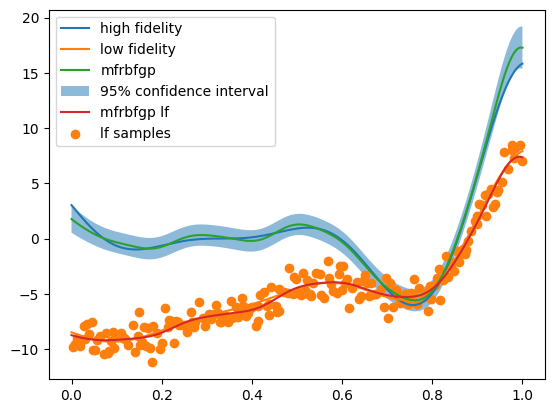

In [10]:
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y3, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y3 - 1.96 * mfrbfgp_pred_std3).flatten(),
    (mfrbfgp_pred_y3 + 1.96 * mfrbfgp_pred_std3).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly3, label="mfrbfgp lf")
ax.scatter(sample_x["lf"], sample_y3["lf"], label="lf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

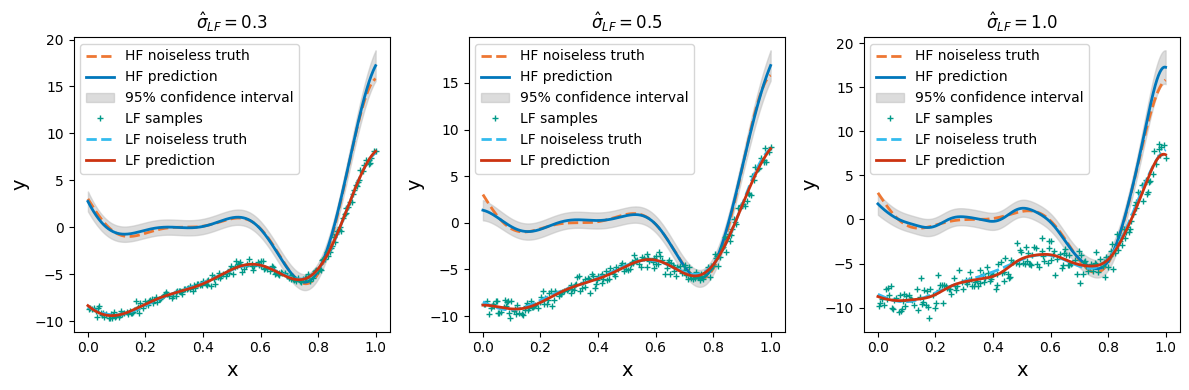

In [11]:
# plot comparison for different noise
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[0].plot(
    test_x, mfrbfgp_pred_y1, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[0].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y1 - 1.96 * mfrbfgp_pred_std1).flatten(),
    (mfrbfgp_pred_y1 + 1.96 * mfrbfgp_pred_std1).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[0].plot(
    sample_x["lf"],
    sample_y1["lf"],
    "+",
    linewidth=2,
    markersize=5,
    color="#009988",
    label="LF samples",
)
ax[0].plot(
    test_x, test_ly, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)
ax[0].plot(test_x, pred_ly1, "-", color="#CC3311",
           linewidth=2, label="LF prediction")

ax[0].legend()
ax[0].set_title(r"$\hat{\sigma}_{LF}= 0.3$")
ax[0].set_xlabel("x", fontsize=14)
ax[0].set_ylabel("y", fontsize=14)
#
ax[1].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[1].plot(
    test_x, mfrbfgp_pred_y2, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y2 - 1.96 * mfrbfgp_pred_std2).flatten(),
    (mfrbfgp_pred_y2 + 1.96 * mfrbfgp_pred_std2).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[1].plot(
    sample_x["lf"],
    sample_y2["lf"],
    "+",
    linewidth=2,
    markersize=5,
    color="#009988",
    label="LF samples",
)
ax[1].plot(
    test_x, test_ly, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)

ax[1].plot(test_x, pred_ly2, "-", color="#CC3311",
           linewidth=2, label="LF prediction")
ax[1].legend()
ax[1].set_title(r"$\hat{\sigma}_{LF}= 0.5$")
ax[1].set_xlabel("x", fontsize=14)
ax[1].set_ylabel("y", fontsize=14)
#
ax[2].plot(
    test_x, test_hy, "--", color="#EE7733", linewidth=2, label="HF noiseless truth"
)
ax[2].plot(
    test_x, mfrbfgp_pred_y3, "-", color="#0077BB", linewidth=2, label="HF prediction"
)
ax[2].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y3 - 1.96 * mfrbfgp_pred_std3).flatten(),
    (mfrbfgp_pred_y3 + 1.96 * mfrbfgp_pred_std3).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label=r"95% confidence interval",
)
ax[2].plot(
    sample_x["lf"],
    sample_y3["lf"],
    "+",
    linewidth=2,
    markersize=5,
    color="#009988",
    label="LF samples",
)
ax[2].plot(
    test_x, test_ly, "--", color="#33BBEE", linewidth=2, label="LF noiseless truth"
)

ax[2].plot(test_x, pred_ly3, "-", color="#CC3311",
           linewidth=2, label="LF prediction")
ax[2].legend()
ax[2].set_title(r"$\hat{\sigma}_{LF}= 1.0$")
ax[2].set_xlabel("x", fontsize=14)
ax[2].set_ylabel("y", fontsize=14)
plt.tight_layout()
plt.savefig("different_noise_influence.png", dpi=300)
plt.savefig("different_noise_influence.pdf", dpi=300)
plt.savefig("different_noise_influence.svg", dpi=300)
plt.show()

In [12]:
# calculate mse, mae, r2 score and log marginal likelihood for different noise
# mse
import pandas as pd

nrmse_1 = normalized_rmse(test_hy, mfrbfgp_pred_y1)
nrmse_2 = normalized_rmse(test_hy, mfrbfgp_pred_y2)
nrmse_3 = normalized_rmse(test_hy, mfrbfgp_pred_y3)

# mae
nmae_1 = normalized_mae(test_hy, mfrbfgp_pred_y1)
nmae_2 = normalized_mae(test_hy, mfrbfgp_pred_y2)
nmae_3 = normalized_mae(test_hy, mfrbfgp_pred_y3)

# r2 score
r2_1 = r2_score(test_hy, mfrbfgp_pred_y1)
r2_2 = r2_score(test_hy, mfrbfgp_pred_y2)
r2_3 = r2_score(test_hy, mfrbfgp_pred_y3)

# log marginal likelihood
logp_1 = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y1, mfrbfgp_pred_std1)
logp_2 = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y2, mfrbfgp_pred_std2)
logp_3 = log_likelihood_value(
    test_hy_noisy, mfrbfgp_pred_y3, mfrbfgp_pred_std3)

print("nrmse: ", nrmse_1, nrmse_2, nrmse_3)
print("nmae: ", nmae_1, nmae_2, nmae_3)
print("r2: ", r2_1, r2_2, r2_3)
print("logp: ", logp_1, logp_2, logp_3)

# save the results to pandas dataframe
df = pd.DataFrame(columns=["mse", "mae", "r2", "logp", "noise"])
df.loc["noise_0.3"] = [nrmse_1, nmae_1, r2_1, logp_1, mfrbfgp1.noise]
df.loc["noise_0.5"] = [nrmse_2, nmae_2, r2_2, logp_2, mfrbfgp2.noise]
df.loc["noise_1.0"] = [nrmse_3, nmae_3, r2_3, logp_3, mfrbfgp3.noise]
print(df)
df.to_csv("different_noise_influence.csv")

nrmse:  0.09582986212900177 0.11000216863351846 0.18039222257209872
nmae:  0.5358136261800615 0.6471873465510797 0.6652429090612677
r2:  0.9969037601778783 0.9959202330109911 0.9890284374293559
logp:  -447.25197415685625 -539.8580373030877 -685.6821033659386
                mse       mae        r2        logp     noise
noise_0.3  0.095830  0.535814  0.996904 -447.251974  0.376675
noise_0.5  0.110002  0.647187  0.995920 -539.858037  0.405343
noise_1.0  0.180392  0.665243  0.989028 -685.682103  0.447450
